In [99]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_rows',None)

In [100]:
data = pd.read_csv('C:/Users/prolo/Downloads/ts.csv')

<Figure size 864x432 with 0 Axes>

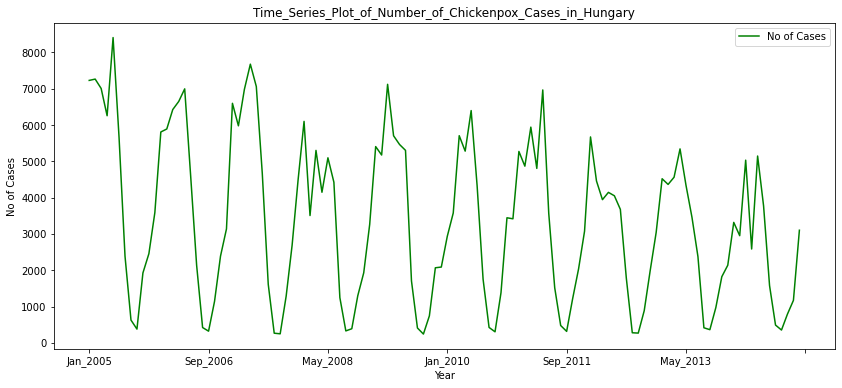

In [101]:
plt.figure(figsize=[12, 6]); # Set dimensions for figure
data.plot(x='Year_Month', y='No of Cases', figsize = (14, 6), legend = True, color='g')
plt.title('Time_Series_Plot_of_Number_of_Chickenpox_Cases_in_Hungary')
plt.ylabel('No of Cases')
plt.xlabel('Year')
plt.xticks()
plt.show()

In [102]:
ad_fuller_result = adfuller(data['No of Cases'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.5516738188943484
p-value: 0.5078119949252962


In [103]:
data['No of Cases'] = np.log(data['No of Cases'])
data['No of Cases'] = data['No of Cases'].diff()
data = data.drop(data.index[0])

In [104]:
ad_fuller_result = adfuller(data['No of Cases'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.191197899503881
p-value: 6.116888175256092e-08


In [105]:
data['No of Cases'] = data['No of Cases'].diff(4)
data = data.drop([1, 2, 3, 4], axis=0).reset_index(drop=True)

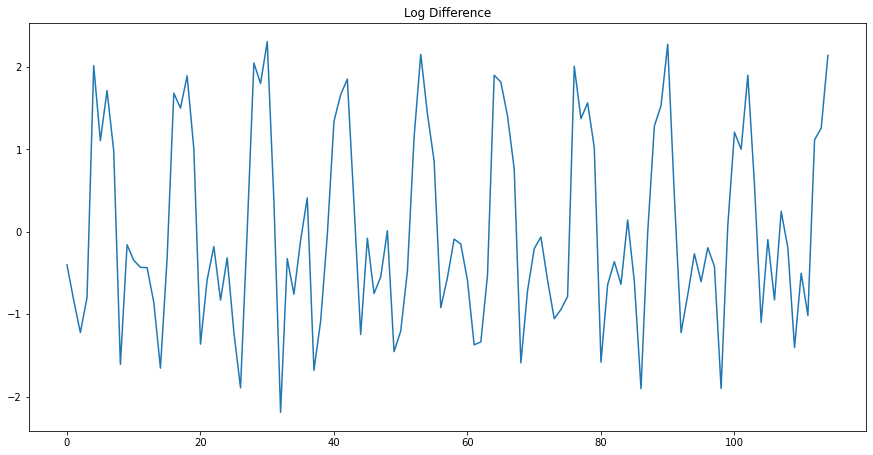

In [106]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['No of Cases'])
plt.title("Log Difference")
plt.show()

In [107]:
ad_fuller_result = adfuller(data['No of Cases'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -9.5933035519142
p-value: 2.0090282017921397e-16


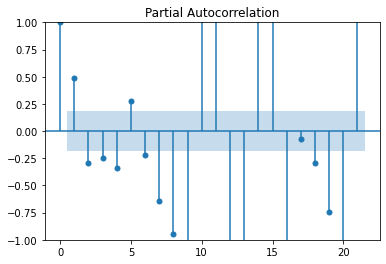

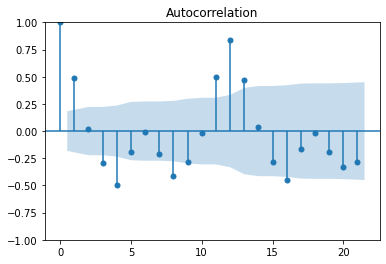

In [108]:
plot_pacf(data['No of Cases']);
plot_acf(data['No of Cases']);

In [125]:
best_model = SARIMAX(data['No of Cases'], order=(1,0,2), seasonal_order=(2, 1, 1, 12)).fit(dis=-1)
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          No of Cases   No. Observations:                  115
Model:             SARIMAX(1, 0, 2)x(2, 1, [1], 12)   Log Likelihood                 -25.122
Date:                              Sun, 08 Jan 2023   AIC                             64.244
Time:                                      18:08:04   BIC                             82.687
Sample:                                           0   HQIC                            71.714
                                              - 115                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4694      0.117     -4.003      0.000      -0.699      -0.240
ma.L1         -0.00

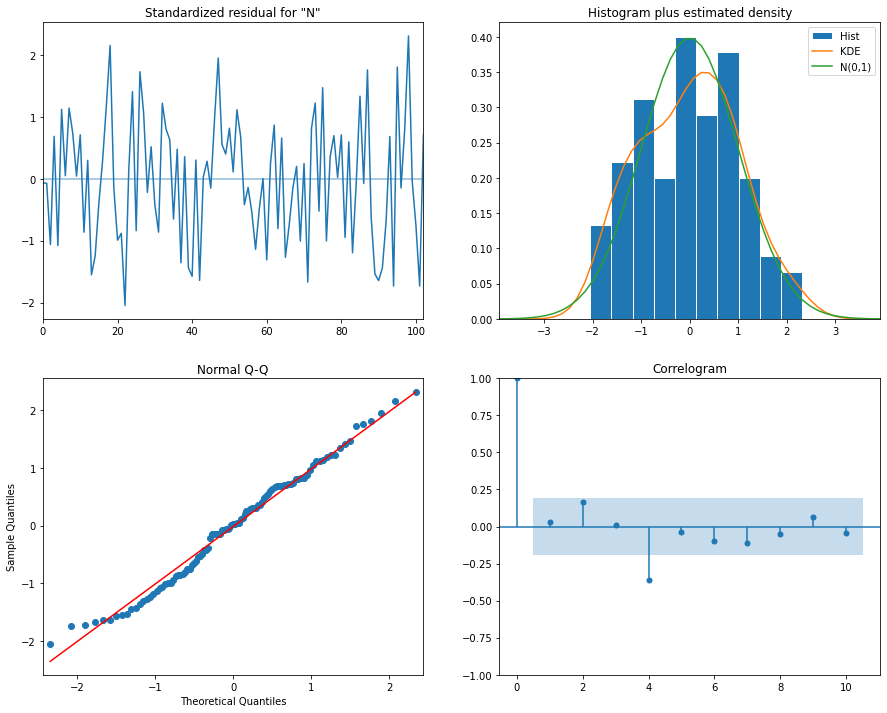

In [126]:
best_model.plot_diagnostics(figsize=(15,12));

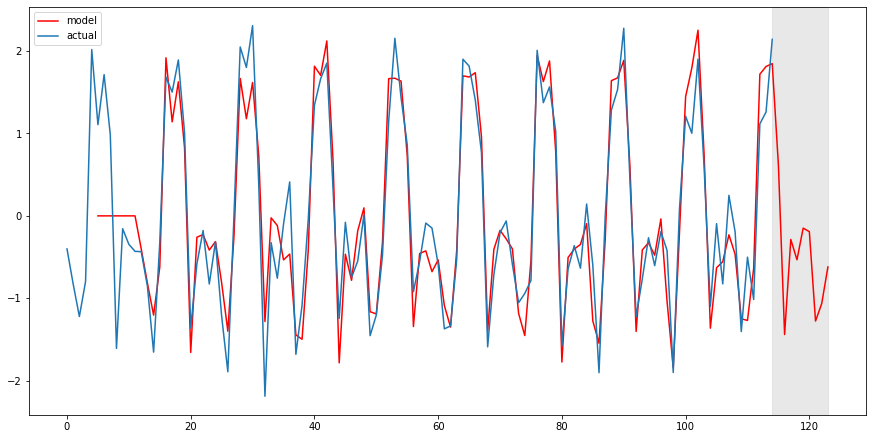

In [110]:
data['arima_model'] = best_model.fittedvalues
data['arima_model'][:4+1] = np.NaN
forecast = best_model.predict(start=data.shape[0], end=data.shape[0] + 8)
forecast = data['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data['No of Cases'], label='actual')
plt.legend()
plt.show()

In [127]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error

train = data[:int(0.85*(len(data)))]
test = data[int(0.85*(len(data))):]
start=len(train)
end=len(train)+len(test)-1
predictions = best_model.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['No of Cases'], predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test['No of Cases'], predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test['No of Cases'], predictions)
evaluation_results['root_mean_squared_error'] = np.sqrt(mean_squared_error(test['No of Cases'], predictions))
 
evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error
0,0.897625,0.307534,0.128624,0.358642
